Disable warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import absl.logging
from datetime import datetime
from scipy import stats

**TransactionDataset :** A class to load the Online transactions dataset. This class also contains the methods to perform data preprocessing, feature extraction.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class TrasactionsDataSet:

  def __init__(self, dataset_path):
    self.file_path = dataset_path
    self.num_cols = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']
    self.cat_cols = ['Payment Method', 'Product Category', 'Customer Location', 'Device Used']
    self.all_columns = []

  def load_data(self):
      try:
          self.data = pd.read_csv(self.file_path)
          self.all_columns = self.data.columns
          self.processed_data = self.data.copy()
          print(f"Data loaded successfully from {self.file_path}")
      except Exception as e:
          print(f"Error loading data: {e}")
          return None

  def process_missing_values(self):

    for c in self.num_cols:
      if(c in self.all_columns):
        self.processed_data[c].fillna(self.processed_data[c].median(), inplace = True)

    for c in self.cat_cols:
      if(c in self.all_columns):
        self.processed_data[c].fillna('Unknown', inplace = True)

  def extract_features(self):
    '''
      Extracts the below features from the existing features
      1. Time Based - Weekend Indicator, Transaction hours binning, Day of the Week
      2. Transaction Amount - Amount Log, Zscore of Amount, Amount/Quantity
      3. Transaction Patterns - Quantity log, Transaction size
      4. Customer profile - New Account Indicator, Age Category, Account Age
      5. Risk Flags - High Quantity, Unusual Hours & High Amount
      6. Location & Device Interaction
    '''
    self.new_features = ['weekend', 'hour_bin', 'day', 'amt_log', 'amt_zsc', 'amt_p_qty', 'qty_log',
                         'trans_sz', 'new_acc', 'age_cat', 'acc_age_wk', 'high_qty', 'unusual_hr',
                         'high_amt', 'dev_loc']

    self.processed_data['weekend'] = (pd.to_datetime(self.processed_data['Transaction Date']).dt.dayofweek >= 5).astype(int)
    self.processed_data['hour_bin'] = pd.cut(self.processed_data['Transaction Hour'],
                                             bins=[-np.inf, 6, 12, 18, np.inf],
                                             labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    self.processed_data['day'] = pd.to_datetime(self.processed_data['Transaction Date']).dt.dayofweek

    self.processed_data['amt_log'] = np.log1p(self.processed_data['Transaction Amount'])
    self.processed_data['amt_zsc'] = stats.zscore(self.processed_data['Transaction Amount'], nan_policy='omit')
    self.processed_data['amt_p_qty'] = self.processed_data['Transaction Amount'] / (self.processed_data['Quantity'] + 1)

    self.processed_data['qty_log'] = np.log1p(self.processed_data['Quantity'])
    self.processed_data['trans_sz'] = pd.qcut(self.processed_data['Transaction Amount'],
                                                      q=5,
                                                      labels=['Very_Small', 'Small', 'Medium', 'Large', 'Very_Large'], duplicates='drop')



    self.processed_data['new_acc'] = (self.processed_data['Account Age Days'] <= 30).astype(int)
    self.processed_data['age_cat'] = pd.cut(self.processed_data['Customer Age'],
                                                 bins=[0, 25, 35, 50, 65, np.inf],
                                                 labels=['Young', 'Young_Adult', 'Adult', 'Senior', 'Elder'])
    self.processed_data['acc_age_wk'] = self.processed_data['Account Age Days'] // 7




    self.processed_data['high_qty'] = (self.processed_data['Quantity'] > self.processed_data['Quantity'].quantile(0.95)).astype(int)
    self.processed_data['unusual_hr'] = ((self.processed_data['Transaction Hour'] < 6) | (self.processed_data['Transaction Hour'] > 22)).astype(int)
    self.processed_data['high_amt'] = (self.processed_data['Transaction Amount'] > self.processed_data['Transaction Amount'].quantile(0.95)).astype(int)

    self.processed_data['dev_loc'] = f"{self.processed_data['Customer Location']}_{self.processed_data['Device Used']}"

  def preprocess_data(self, training=True, lbl_encoders=None):

    self.process_missing_values()
    self.extract_features()
    cat_cols = self.cat_cols + ['hour_bin', 'age_cat', 'trans_sz', 'dev_loc']
    if training:
        lbl_encoders = {}
        for c in cat_cols:
            if c in self.processed_data.columns:
                lbl_encoders[c] = LabelEncoder()
                self.processed_data[c] = lbl_encoders[c].fit_transform(self.processed_data[c])
        return self.processed_data, lbl_encoders
    else:
        for c in cat_cols:
            if c in self.processed_data.columns and c in lbl_encoders:
                self.processed_data[c] = self.processed_data[c].map(lambda x: 'Unknown' if x not in lbl_encoders[c].classes_ else x)
                if 'Unknown' not in lbl_encoders[c].classes_:
                    lbl_encoders[c].classes_ = np.append(lbl_encoders[c].classes_, 'Unknown')
                self.processed_data[c] = lbl_encoders[c].transform(self.processed_data[c])
        return self.processed_data

  def get_cols(self):
    return self.num_cols + self.cat_cols + self.new_features

**DataSampler:** This class provides a staticmethod that is used to balance the data using the specified data samplng technique

In [ ]:
class DataSampler:

    @staticmethod
    def balance_data(X, y, method):
      print(f"Distribution before - {method}:\n", y.value_counts())
      balancer = method(random_state=42)
      X_resampled, y_resampled = balancer.fit_resample(X, y)
      print(f"\nDistribution after - {method}:\n", y_resampled.value_counts())
      return X_resampled, y_resampled

Import the required modules and classes to setup the ML models

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import gc

**BaseModel :** This class is used to train the specified base models using the train data and also provides functionality to evaluate the base models by calculating the metrics like - ROC AUC, Accuracy, Precision, Recall, and confusion matrix

In [ ]:
class BaseModel:

    def __init__(self, models):
        self.models = models
        self.best_models = {}

    def train(self, X_train, y_train):
        for model_name, model in self.models.items():
            model.fit(X_train, y_train)
            self.best_models[model_name] = model
            gc.collect()

    def evaluate(self, X_val, y_val):
        results = {}
        for model_name, model in self.best_models.items():
            y_pred = model.predict(X_val)
            y_prob = model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_prob)
            results[model_name] = {
                'ROC AUC': auc(fpr, tpr),
                'Accuracy': accuracy_score(y_val, y_pred),
                'F1 Score': f1_score(y_val, y_pred),
                'Precision': precision_score(y_val, y_pred),
                'Recall': recall_score(y_val, y_pred),
                'y_prob': y_prob,
                'Confusion Matrix': confusion_matrix(y_val, y_pred)
            }
        return results

Importing the required modules and classes to setup the Feed Forward Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

phys_devices = tf.config.list_physical_devices('GPU')
if len(phys_devices) > 0:
    print("GPU is available: ", phys_devices)
    try:
        for device in phys_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except Exception as e:
        print(f"Memory Error {e}")
else:
    print("GPU is not available. So, defaulting to CPU.")

GPU is not available. So, defaulting to CPU.


**FNNModel :** This class initializes FNN and also provides functionality to train and evaluate the NN model

In [ ]:
class FNNModel:

    def __init__(self, input_dim,
                 act_fun = 'relu',
                 act_fun_fin = 'sigmoid',
                 dropout = 0.5,
                 optim = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['AUC']):

        self.model = Sequential([Input(shape=(input_dim,)),
            Dense(1024, activation=act_fun),
            BatchNormalization(),
            Dropout(dropout),
            Dense(512, activation=act_fun),
            BatchNormalization(),
            Dropout(dropout),
            Dense(256, activation=act_fun),
            BatchNormalization(),
            Dropout(dropout),
            Dense(1, activation=act_fun_fin)
        ])
        self.model.compile(optimizer=optim, loss=loss, metrics=metrics)

    def train(self, X_train, y_train, X_val, y_val, epochs = 200, bs = 256):
        erly_stpng = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=bs, validation_data=(X_val, y_val), callbacks=[erly_stpng], verbose=0)

    def evaluate(self, X_val, y_val):
        y_prob = self.model.predict(X_val).flatten()
        y_pred = (y_prob > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        return {
            'ROC AUC': auc(fpr, tpr),
            'Accuracy': accuracy_score(y_val, y_pred),
            'F1 Score': f1_score(y_val, y_pred),
            'Precision': precision_score(y_val, y_pred),
            'Recall': recall_score(y_val, y_pred),
            'y_prob': y_prob,
            'Confusion Matrix': confusion_matrix(y_val, y_pred)
        }

**Ensemble Model :** This class has the implementation of the proposed Ensemble model and it also provides functionality for training, prediction and evaluating the model.

In [ ]:
class EnsembleModel:

    def __init__(self, base_models, fnn_model):
        self.bs_mdls = base_models
        self.fnn_mdl = fnn_model
        self.wghts = None

    def train(self, X_val, y_val):
        bs_preds = np.column_stack([mdl.predict_proba(X_val)[:, 1] for mdl in self.bs_mdls.values()])
        fnn_preds = self.fnn_mdl.model.predict(X_val).flatten()
        all_preds = np.column_stack([bs_preds, fnn_preds])
        meta_clf = LogisticRegression()
        meta_clf.fit(all_preds, y_val)
        self.wghts = meta_clf.coef_[0] / np.sum(meta_clf.coef_[0])

    def predict(self, X_val):
        bs_preds = np.column_stack([mdl.predict_proba(X_val)[:, 1] for mdl in self.bs_mdls.values()])
        fnn_preds = self.fnn_mdl.model.predict(X_val).flatten()
        all_preds = np.column_stack([bs_preds, fnn_preds])
        return np.dot(all_preds, self.wghts)

    def evaluate(self, X_val, y_val):
        y_prob = self.predict(X_val)
        y_pred = (y_prob > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        return {
            'ROC AUC': auc(fpr, tpr),
            'Accuracy': accuracy_score(y_val, y_pred),
            'F1 Score': f1_score(y_val, y_pred),
            'Precision': precision_score(y_val, y_pred),
            'Recall': recall_score(y_val, y_pred),
            'y_prob': y_prob,
            'Confusion Matrix': confusion_matrix(y_val, y_pred)
        }

**Evaluator :** This class provides the functionality to display the plots of various metrics to compare the performance of various models.

In [ ]:
class Evaluator:

  def __init__(self):
    pass

  def set_metrics(self, model_res):
    self.model_res = model_res
    self.model_names = []
    self.metric_names = []
    self.__set_models_and_metrics_names()

  def __set_models_and_metrics_names(self):
      metric_items = list(self.model_res.items())
      self.model_names = [item[0] for item in metric_items]
      self.metric_names = list(metric_items[0][1].keys())

  def plot_metrics(self):

      fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 20))

      for idx, axes in enumerate((ax1, ax2, ax3, ax4)):
        axes.bar(self.model_names, [self.model_res[model][self.metric_names[idx]] for model in self.model_names])
        axes.set_title(self.metric_names[idx])
        for i, model in enumerate(self.model_names):
            val = self.model_res[model][self.metric_names[idx]]
            axes.text(i, val + 0.01, f'{val:.4f}', ha='center', va='bottom')

      plt.tight_layout()
      plt.show()

  def plot_conf_mat(self):

      fig, axes = plt.subplots(2, 3, figsize=(20, 12))
      for i, model in enumerate(self.model_names):
          axs = axes[i // 3, i % 3]
          confusion = self.model_res[model]['Confusion Matrix']
          im = axs.imshow(confusion, cmap='Blues')
          axs.set_title(f'Confusion Matrix : {model}')
          axs.set_xlabel('Predicted')
          axs.set_ylabel('Actual')
          for x in range(confusion.shape[0]):
              for y in range(confusion.shape[1]):
                  axs.text(y, x, f'{confusion[x, y]}', ha='center', va='center', color='black')
          fig.colorbar(im, ax=axs)

      plt.tight_layout()
      plt.show()

  def plot_auc_roc(self, y_val):

      plt.figure(figsize=(12, 8))
      ls = {'FNN' : '-.', 'Ensemble' : '--'}
      for model, metrics in self.model_res.items():
          fpr, tpr, _ = roc_curve(y_val, metrics['y_prob'])
          if(model in ls):
            plt.plot(fpr, tpr, label=f'{model} (AUC: {metrics["ROC AUC"]:.4f})', linestyle = ls[model])
          else:
            plt.plot(fpr, tpr, label=f'{model} (AUC: {metrics["ROC AUC"]:.4f})')
      plt.title('ROC Curve Comparison')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend(loc='lower right')
      plt.grid()
      plt.show()

Invoking Evaluator

In [ ]:
evaluator = Evaluator()

Invoking DataSampler

In [ ]:
sampler = DataSampler()

Initializing the Base Models

In [ ]:
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')
rf_model = RandomForestClassifier(n_estimators=500, max_depth=30, n_jobs=-1)
xgb_model = xgb.XGBClassifier(n_estimators=1000, max_depth=15, learning_rate=0.01, tree_method='hist', use_label_encoder=False)
models = {'Logistic Regression':lr_model, 'Random Forest':rf_model, 'XGBoost':xgb_model}

**train_and_evaluate :** This method provides the functionality to perform oversampling of data using various methods and also trains and evaluates the models for the performance analysis.

In [ ]:
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN

def train_and_evaluate(train_data, test_data):

    train_df, label_encoders = train_data.preprocess_data(training=True)
    test_df = test_data.preprocess_data(training=False, lbl_encoders=label_encoders)

    features = train_data.get_cols()
    print(features)
    X = train_df[features]
    y = train_df['Is Fraudulent']

    for method in [SMOTE, ADASYN, SVMSMOTE]:

      X_resampled, y_resampled = sampler.balance_data(X, y, method)

      X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
      # X_train, Y_train = X, y
      # X_val, Y_val = test_df[features], train_df['Is Fradulent']


      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)
      X_val_scaled = scaler.transform(X_val)

      base_trainer = BaseModel(models)
      base_trainer.train(X_train_scaled, y_train)
      results = base_trainer.evaluate(X_val_scaled, y_val)

      input_dim = X_train_scaled.shape[1]
      fnn_mdl = FNNModel(input_dim=input_dim)
      fnn_mdl.train(X_train_scaled, y_train, X_val_scaled, y_val)
      fnn_res = fnn_mdl.evaluate(X_val_scaled, y_val)
      results["FNN"] = fnn_res

      ens_mdl = EnsembleModel(base_models=base_trainer.best_models, fnn_model=fnn_mdl)
      ens_mdl.train(X_val_scaled, y_val)
      ens_res = ens_mdl.evaluate(X_val_scaled, y_val)
      results["Ensemble"] = ens_res

      rf_model = RandomForestClassifier(n_estimators=500, max_depth=30, n_jobs=-1)
      rf_model.fit(X_train_scaled, y_train)
      imp_features = rf_model.feature_importances_
      plt.figure(figsize=(12, 8))
      plt.barh(features, imp_features)
      plt.xlabel('Feature Importance')
      plt.ylabel('Feature')
      plt.title('Feature Importance')
      plt.show()

      metrics_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
      metrics_df = metrics_df.rename(columns={"index": "Model"})
      print(metrics_df)
      evaluator.set_metrics(results)
      evaluator.plot_auc_roc(y_val)
      evaluator.plot_metrics()
      evaluator.plot_conf_mat()

In [ ]:
train_data = TrasactionsDataSet('/content/Fraudulent_E-Commerce_Transaction_Data.csv')
train_data.load_data()
test_data = TrasactionsDataSet('/content/Fraudulent_E-Commerce_Transaction_Data_2.csv')
test_data.load_data()

['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'Payment Method', 'Product Category', 'Customer Location', 'Device Used', 'weekend', 'hour_bin', 'day', 'amt_log', 'amt_zsc', 'amt_p_qty', 'qty_log', 'trans_sz', 'new_acc', 'age_cat', 'acc_age_wk', 'high_qty', 'unusual_hr', 'high_amt', 'dev_loc']
Distribution before - <class 'imblearn.over_sampling._smote.base.SMOTE'>:
 Is Fraudulent
0    22412
1     1222
Name: count, dtype: int64

Distribution after - <class 'imblearn.over_sampling._smote.base.SMOTE'>:
 Is Fraudulent
0    22412
1    22412
Name: count, dtype: int64
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


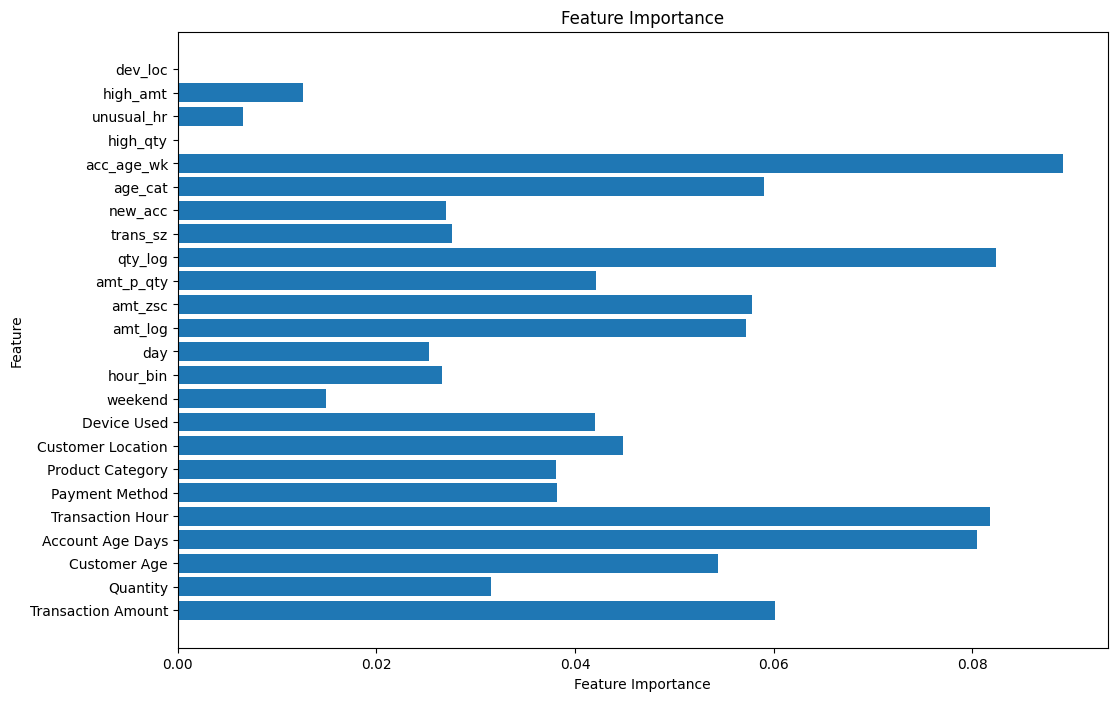

                 Model   ROC AUC  Accuracy  F1 Score  Precision    Recall  \
0  Logistic Regression  0.942004  0.868154  0.867012   0.874489  0.859661   
1        Random Forest  0.991614  0.958059  0.958111   0.956831  0.959393   
2              XGBoost  0.994747  0.972002  0.971706   0.982000  0.961624   
3                  FNN  0.989737  0.956721  0.955969   0.972748  0.939759   
4             Ensemble  0.994680  0.972337  0.972097   0.980481  0.963855   

                                              y_prob  \
0  [0.9426357827304445, 0.8147244493373683, 0.995...   
1  [0.9757851851851851, 0.75, 0.984, 0.9979761904...   
2  [0.9998286, 0.9649044, 0.9995907, 0.9979081, 0...   
3  [0.9999959, 0.99943954, 0.9997714, 0.9929238, ...   
4  [0.9989757400305853, 0.9025936611743439, 0.993...   

             Confusion Matrix  
0  [[3930, 553], [629, 3853]]  
1  [[4289, 194], [182, 4300]]  
2   [[4404, 79], [172, 4310]]  
3  [[4365, 118], [270, 4212]]  
4   [[4397, 86], [162, 4320]]  


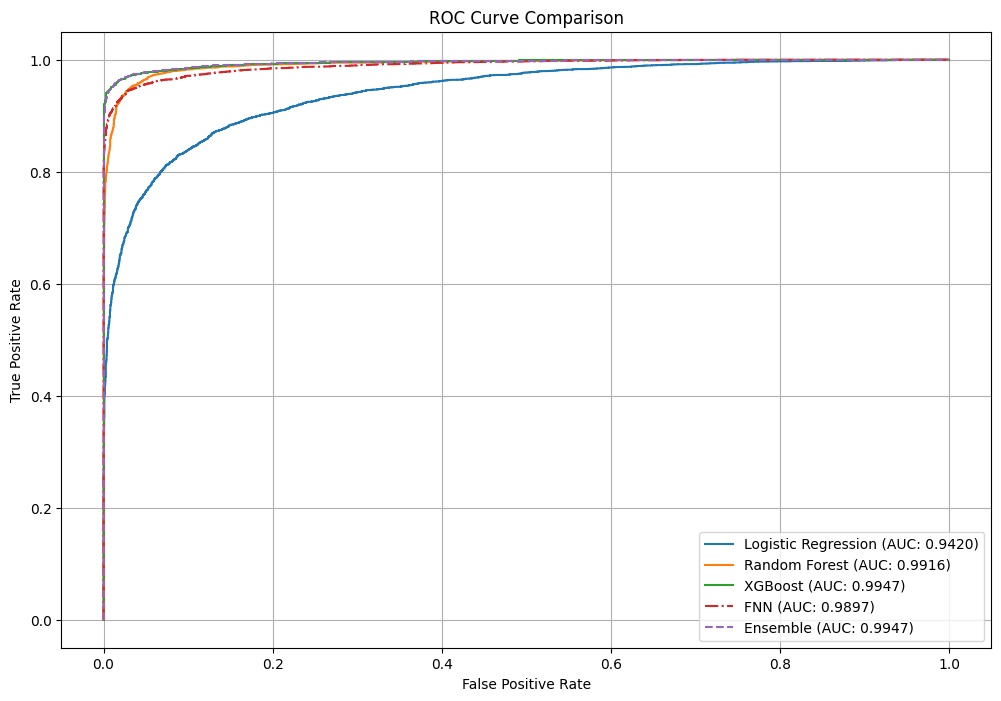

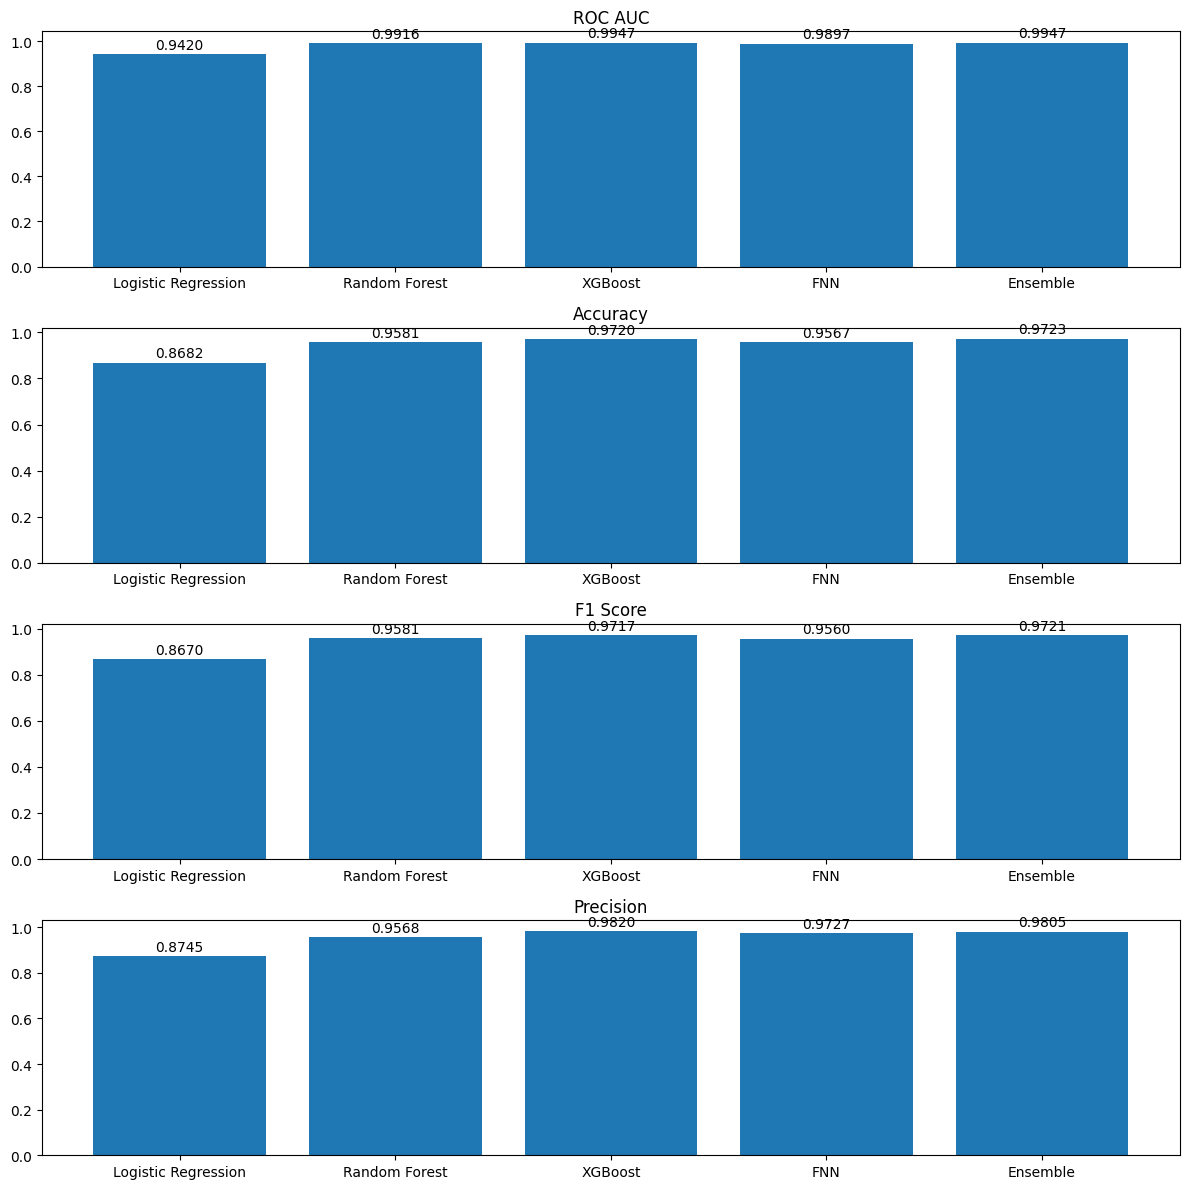

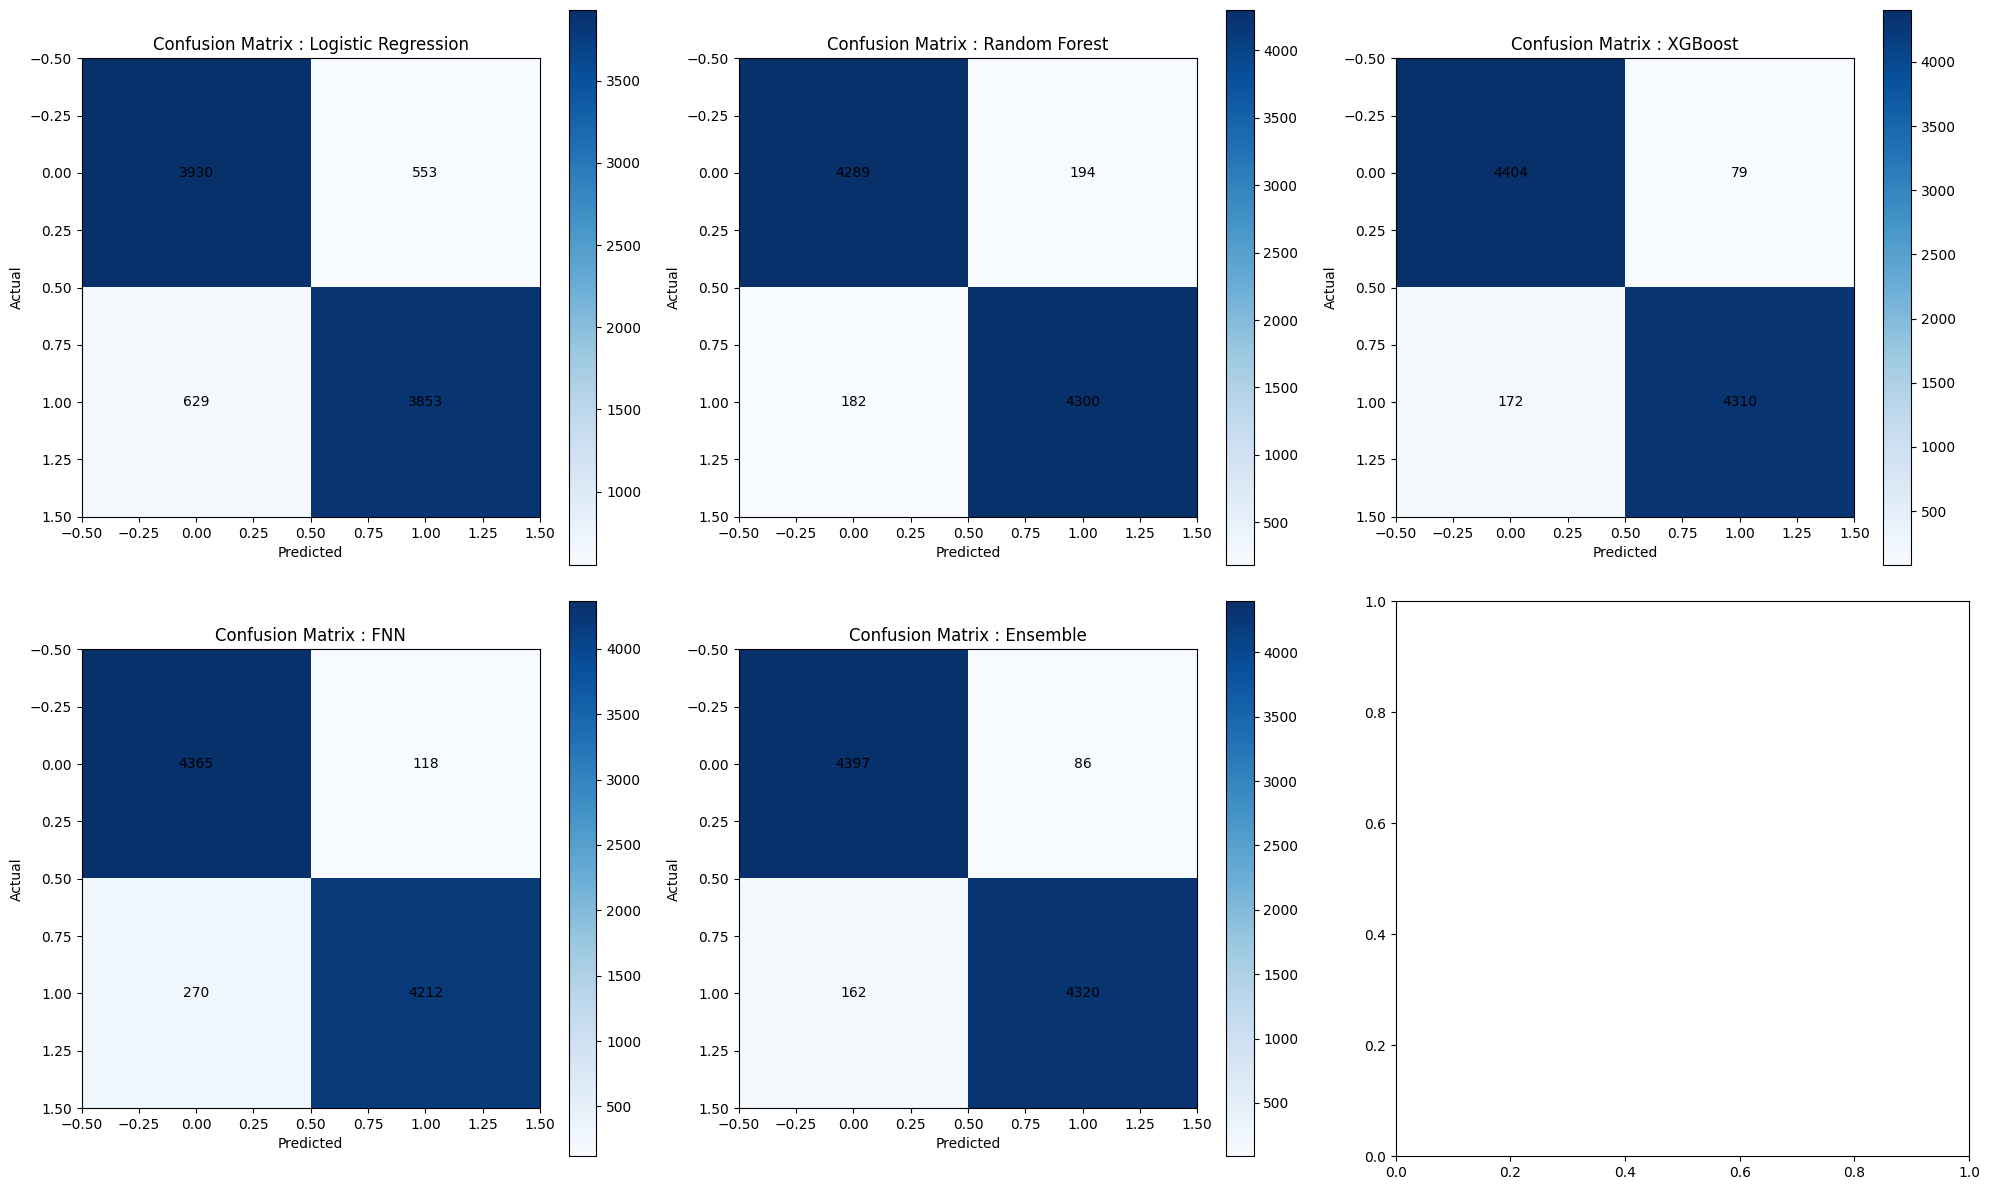

Distribution before - <class 'imblearn.over_sampling._adasyn.ADASYN'>:
 Is Fraudulent
0    22412
1     1222
Name: count, dtype: int64

Distribution after - <class 'imblearn.over_sampling._adasyn.ADASYN'>:
 Is Fraudulent
1    22515
0    22412
Name: count, dtype: int64
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


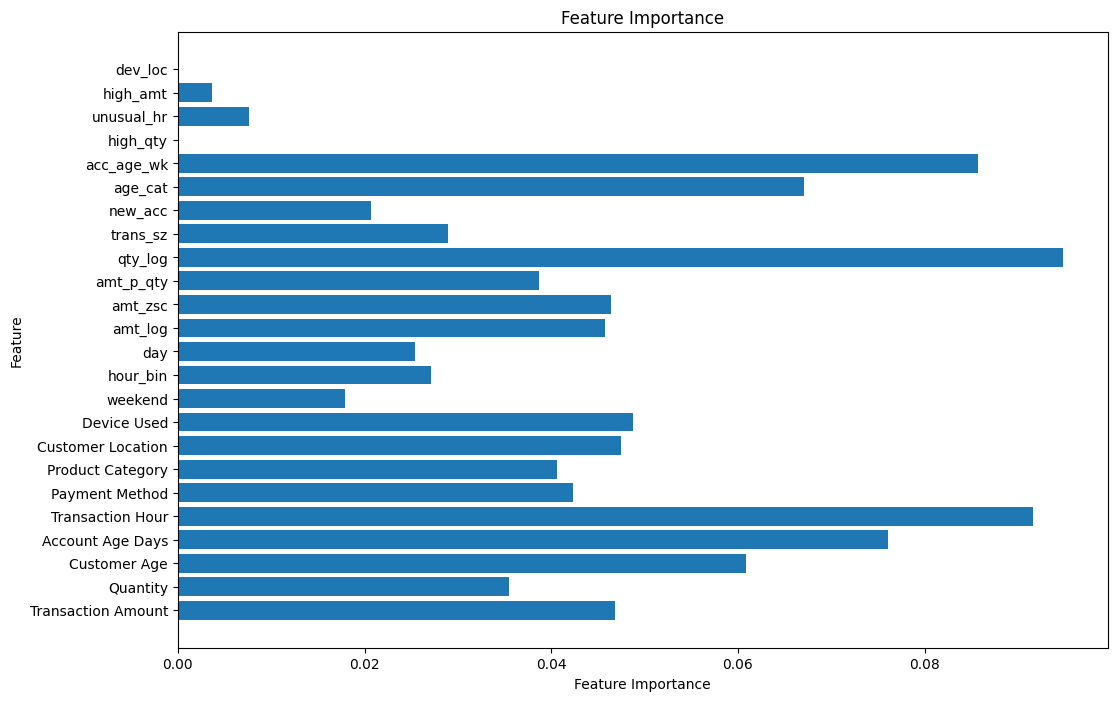

                 Model   ROC AUC  Accuracy  F1 Score  Precision    Recall  \
0  Logistic Regression  0.937688  0.860672  0.859955   0.866351  0.853653   
1        Random Forest  0.992266  0.960383  0.960732   0.954416  0.967133   
2              XGBoost  0.994741  0.972290  0.972107   0.980787  0.963580   
3                  FNN  0.990851  0.960939  0.960254   0.979667  0.941594   
4             Ensemble  0.995619  0.972847  0.972658   0.981678  0.963802   

                                              y_prob  \
0  [0.09395510725251666, 0.9677284287910067, 0.12...   
1  [0.088, 0.9594152046783627, 0.004, 0.056, 0.90...   
2  [0.0056812074, 0.9999316, 0.0017717353, 0.0026...   
3  [0.0014021003, 0.99998564, 0.0007845791, 0.000...   
4  [0.023339622365190583, 0.988660401968662, -0.0...   

             Confusion Matrix  
0  [[3890, 593], [659, 3844]]  
1  [[4275, 208], [148, 4355]]  
2   [[4398, 85], [164, 4339]]  
3   [[4395, 88], [263, 4240]]  
4   [[4402, 81], [163, 4340]]  


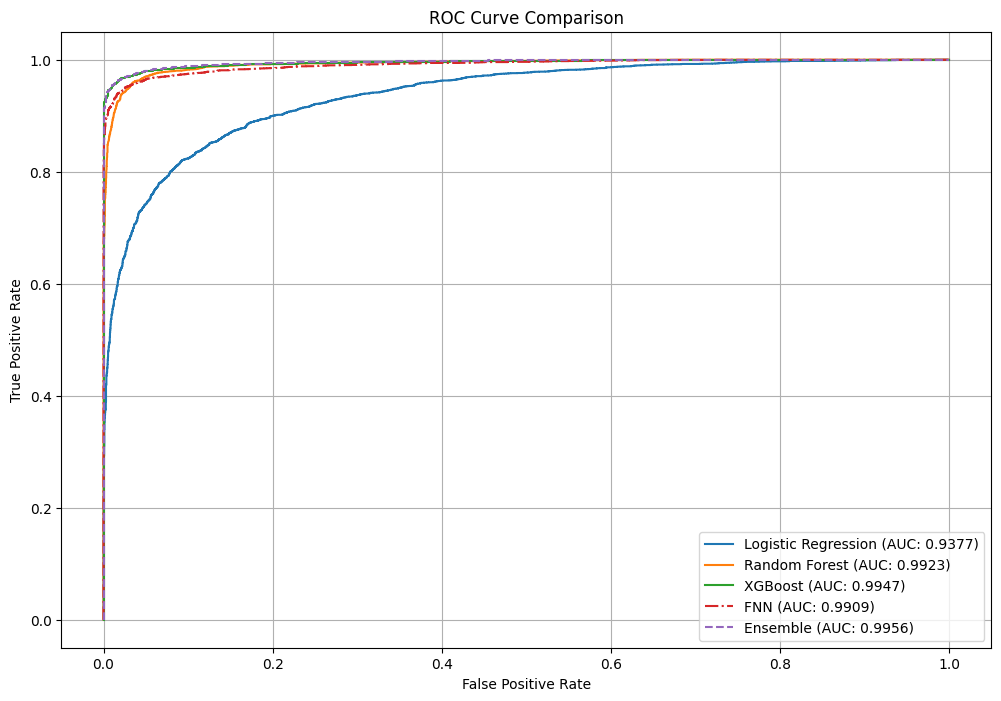

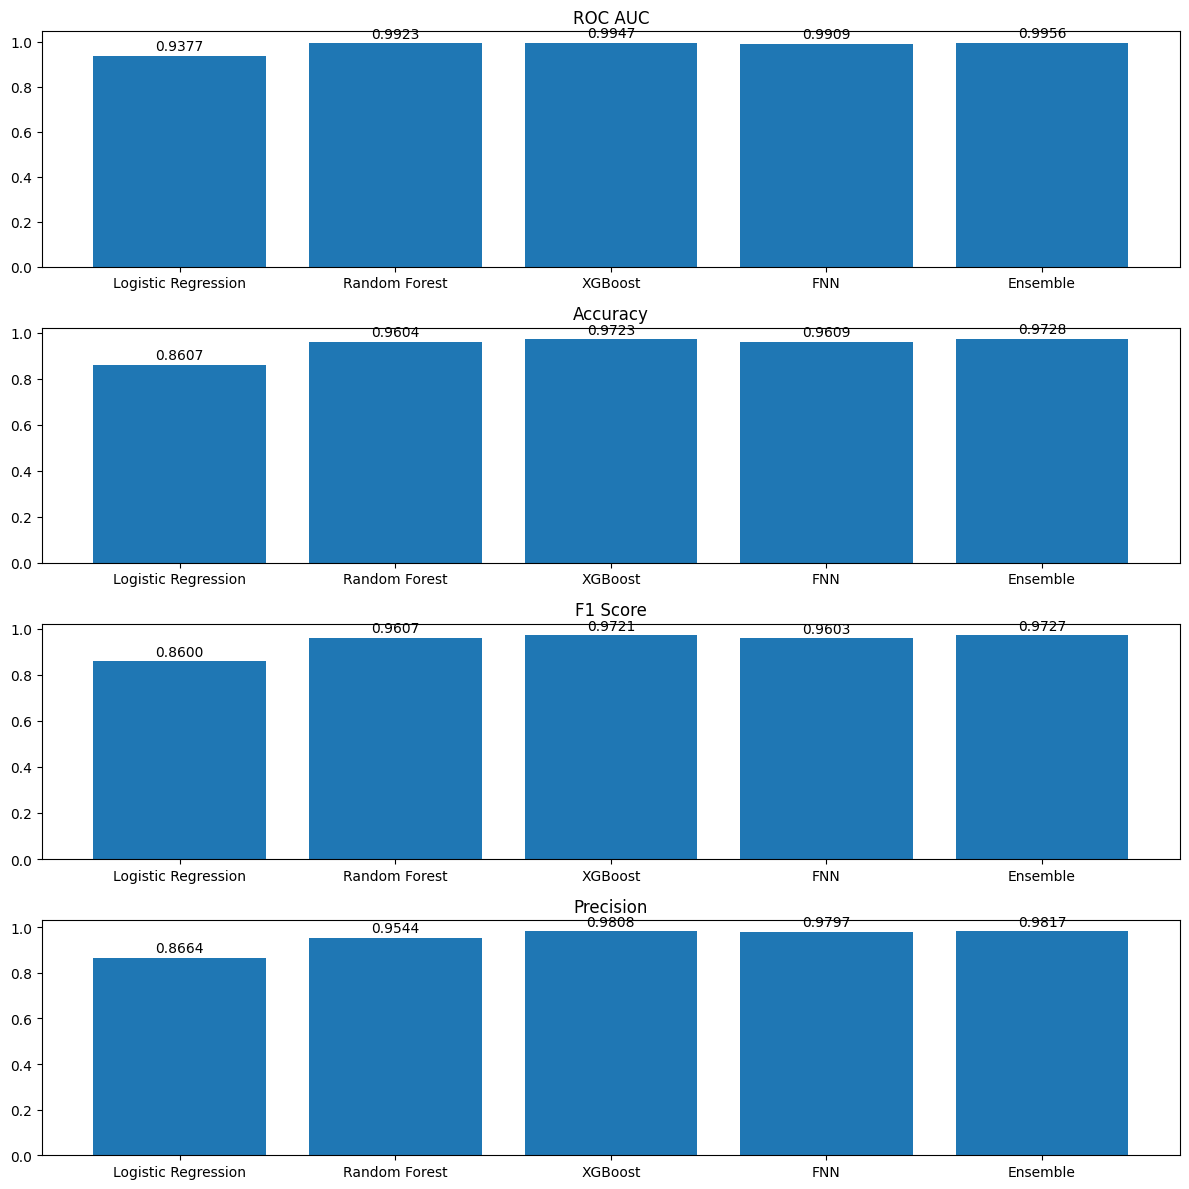

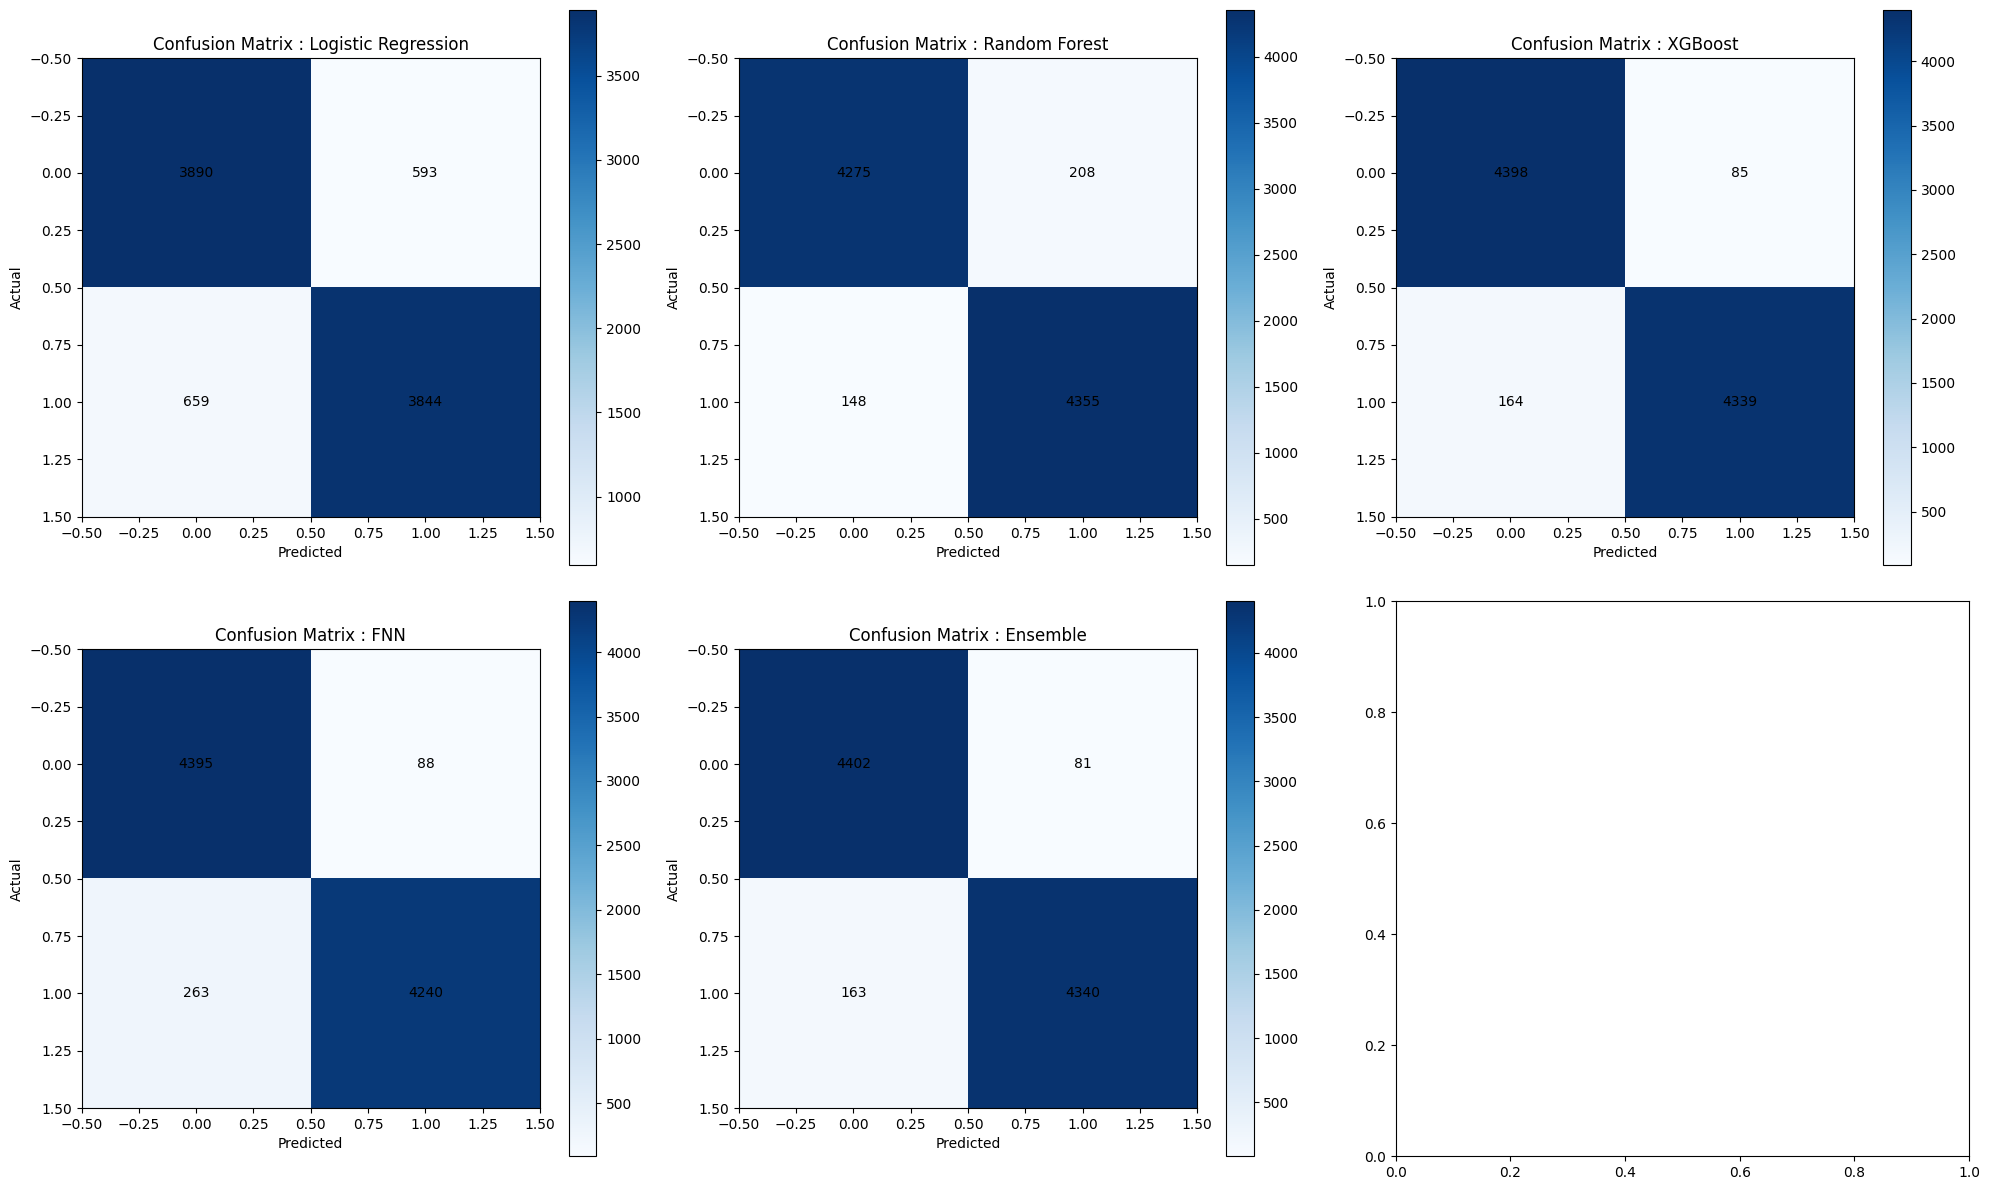

Distribution before - <class 'imblearn.over_sampling._smote.filter.SVMSMOTE'>:
 Is Fraudulent
0    22412
1     1222
Name: count, dtype: int64

Distribution after - <class 'imblearn.over_sampling._smote.filter.SVMSMOTE'>:
 Is Fraudulent
0    22412
1    22412
Name: count, dtype: int64
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


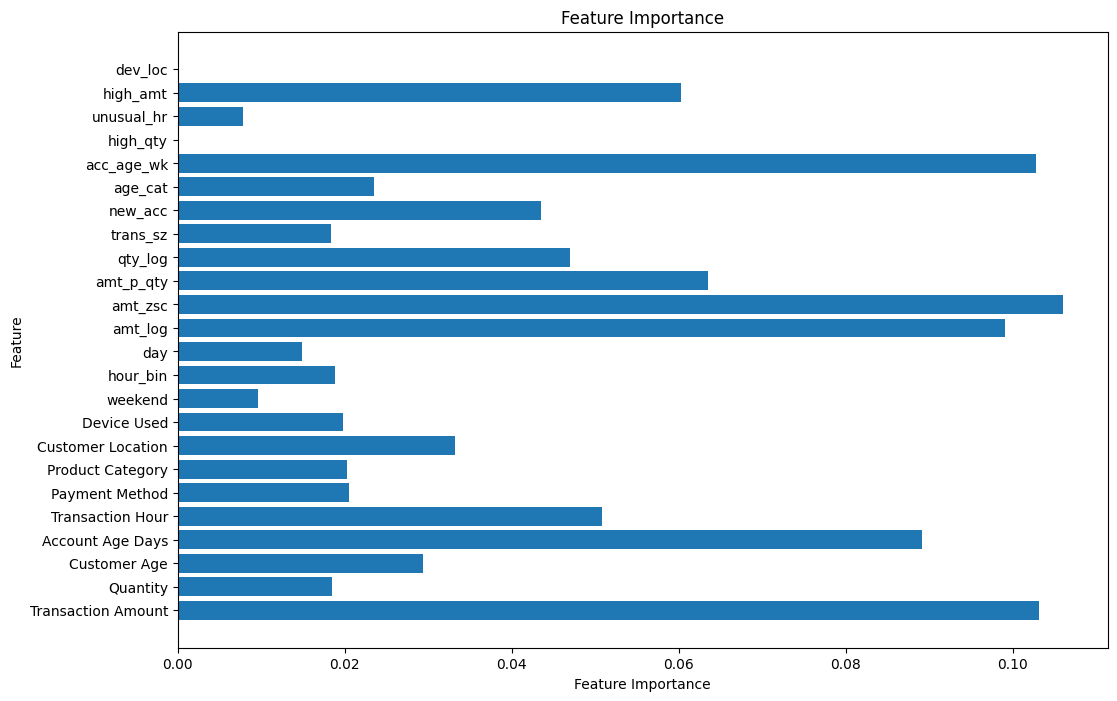

                 Model   ROC AUC  Accuracy  F1 Score  Precision    Recall  \
0  Logistic Regression  0.965570  0.907864  0.906136   0.923344  0.889558   
1        Random Forest  0.990892  0.962075  0.961977   0.964350  0.959616   
2              XGBoost  0.992381  0.972560  0.972328   0.980490  0.964302   
3                  FNN  0.990308  0.962075  0.961187   0.984105  0.939313   
4             Ensemble  0.992479  0.972560  0.972266   0.982680  0.962071   

                                              y_prob  \
0  [0.7518979844753267, 0.9792530156146502, 0.911...   
1  [0.7, 0.994, 0.846, 1.0, 0.998, 0.752, 0.976, ...   
2  [0.95666, 0.9983552, 0.9951009, 0.9983291, 0.9...   
3  [0.99999505, 0.9999254, 0.9999774, 0.9999926, ...   
4  [0.9085613166982538, 1.0007829291599741, 0.954...   

             Confusion Matrix  
0  [[4152, 331], [495, 3987]]  
1  [[4324, 159], [181, 4301]]  
2   [[4397, 86], [160, 4322]]  
3   [[4415, 68], [272, 4210]]  
4   [[4407, 76], [170, 4312]]  


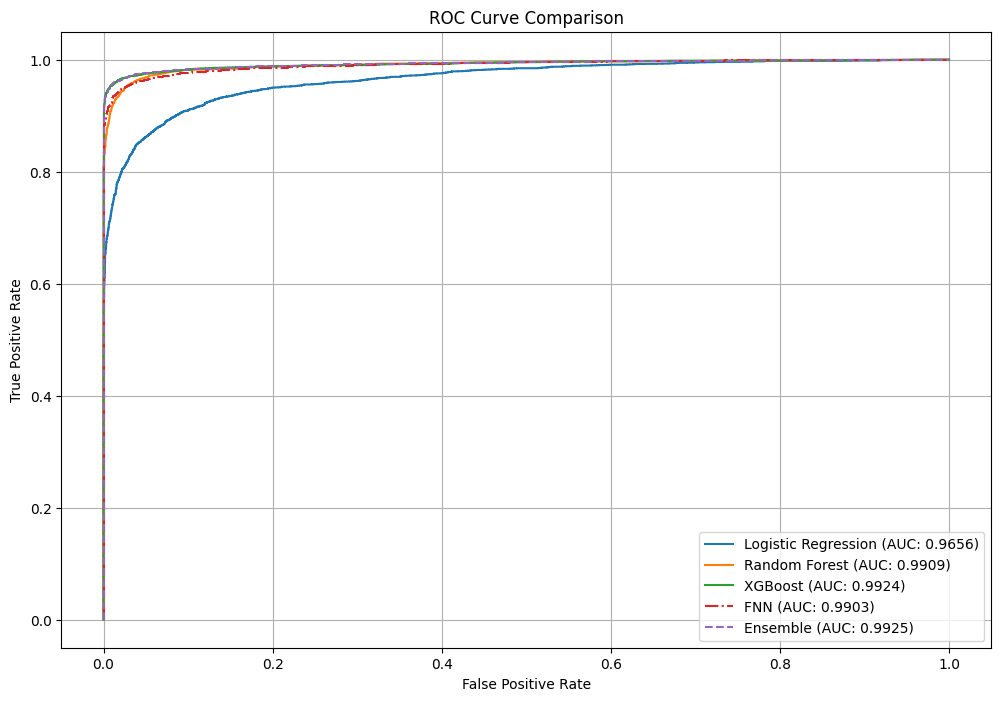

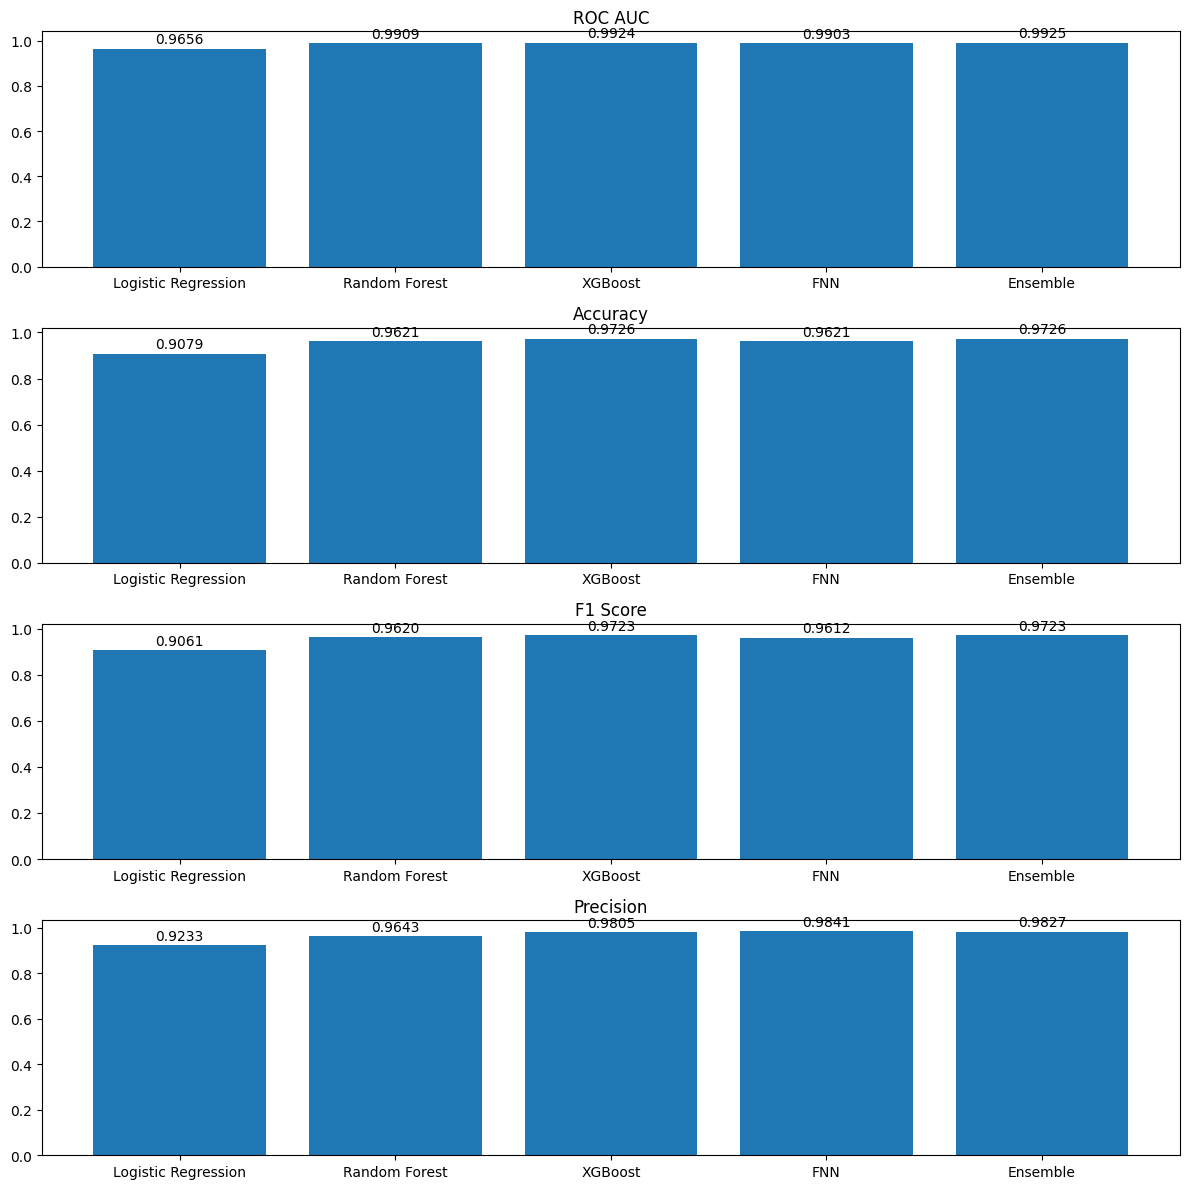

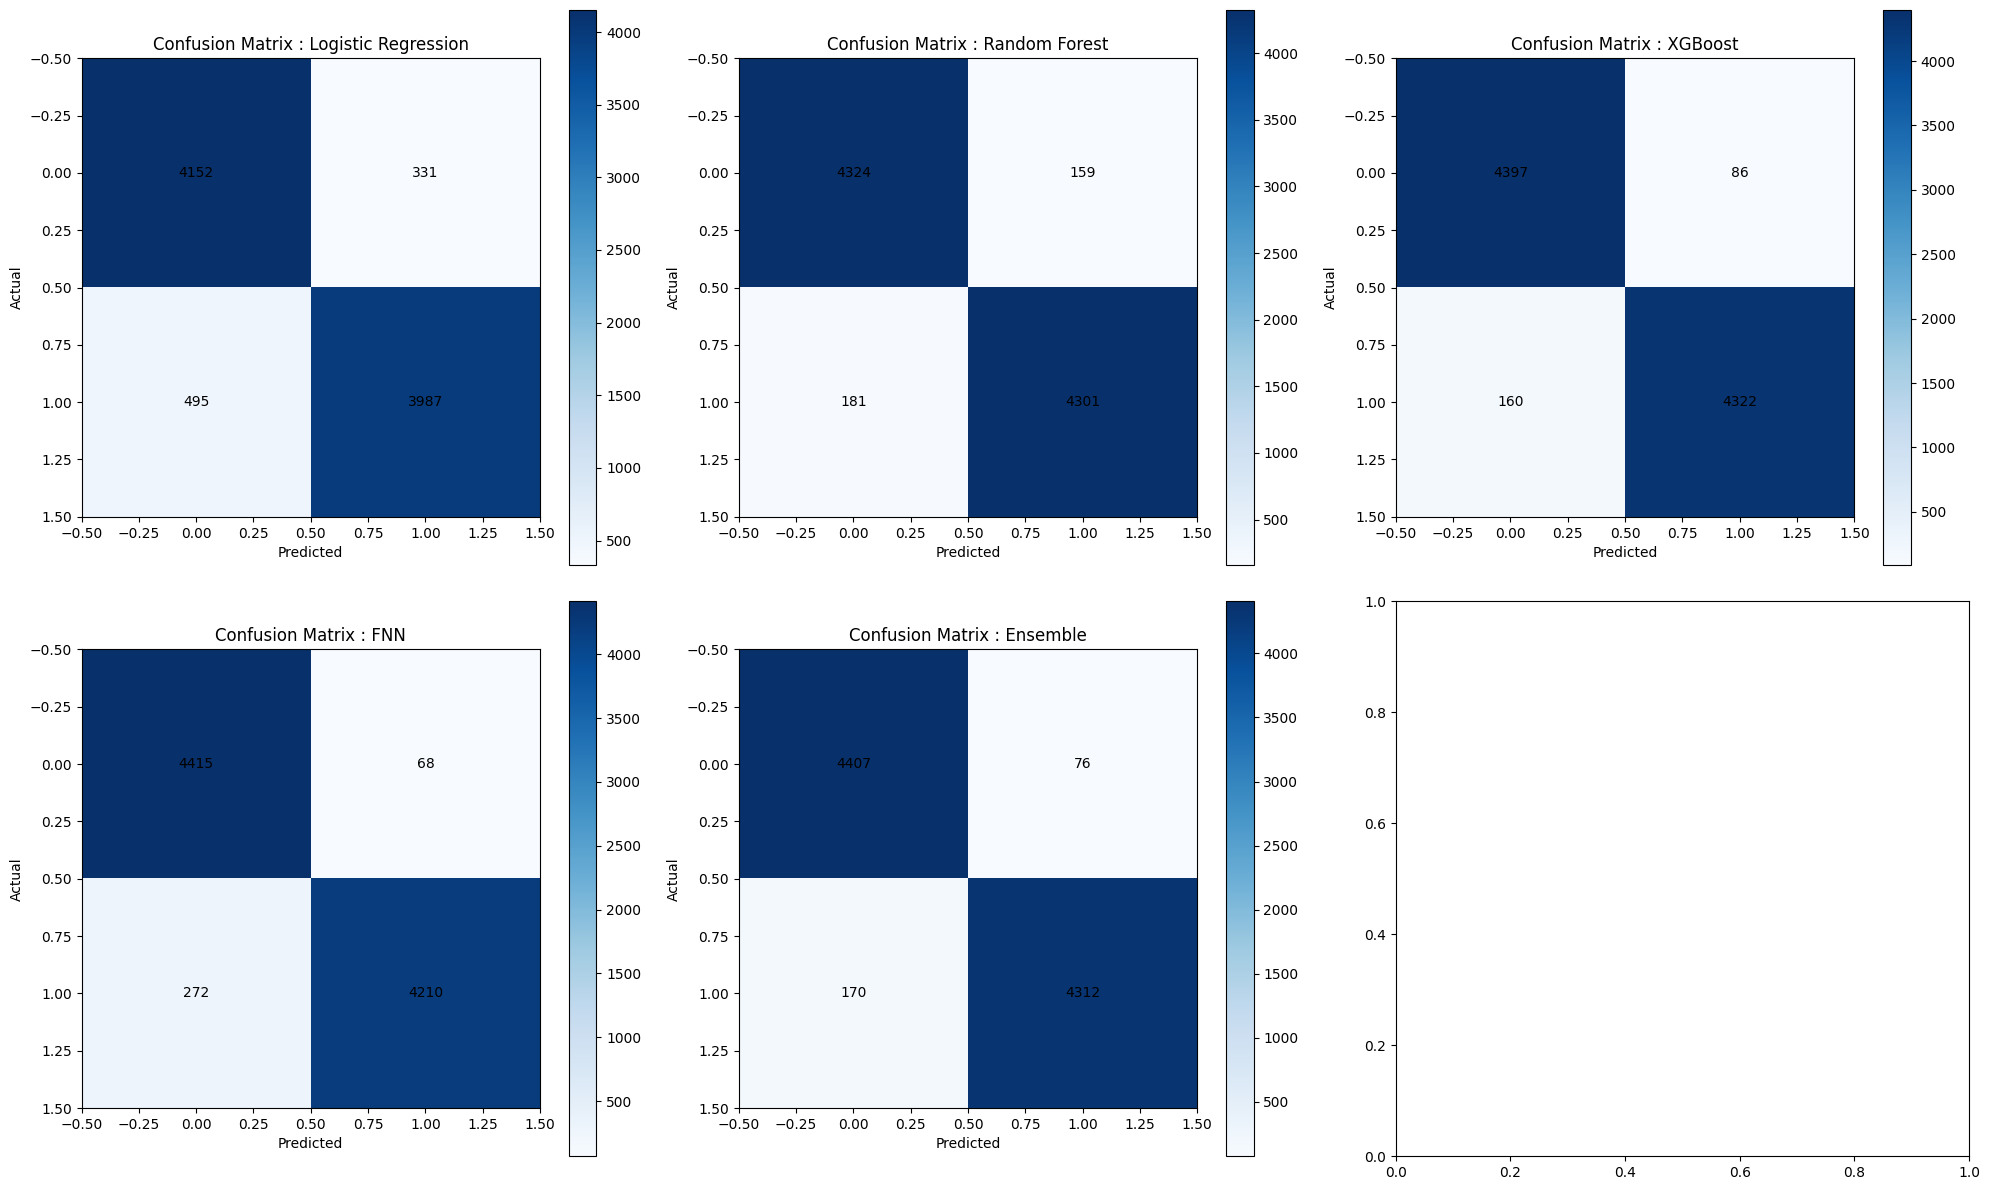

In [ ]:
train_and_evaluate(train_data, test_data)